<a href="https://colab.research.google.com/github/HelloShagun/useful_libs/blob/main/examples/end_to_end_fish_ponds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Fish pond maching

In [ ]:
!pip install contextily leafmap
import os, sys, importlib
import numpy as np
import pandas as pd


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 662.8/662.8 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.4/20.4 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.5/208.5 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.7 MB/s eta 0:00:00
  Attempting uninstall: duckdb
    Found existing installation: duckdb 1.3.2
    Uninstalling duckdb-1.3.2:
      Successfully uninstalled duckdb-1.3.2


In [ ]:
!git clone https://github.com/HelloShagun/useful_libs
from google.colab import output
output.enable_custom_widget_manager()
import sys
sys.path.append("/content/useful_libs/")


##### collab
from google.colab import drive
drive.mount('/content/drive')


Cloning into 'useful_libs'...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 87 (delta 24), reused 16 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (87/87), 9.36 MiB | 7.01 MiB/s, done.
Resolving deltas: 100% (24/24), done.
Mounted at /content/drive


In [ ]:
from lake_maps_comparison.io_stack import read_stack, get_band_mask
from lake_maps_comparison.morphology import MorphologyConfig, clean_mask
from lake_maps_comparison.objects import ObjectConfig, label_and_stats
from lake_maps_comparison.matching import MatchConfig, union_masks, match_objects_labels_to_mask
from lake_maps_comparison.vectorize import labels_to_geodataframe
from lake_maps_comparison.wayback_export import export_wayback_panels, ExportStyle

In [ ]:


# ---- 2) USER CONFIG (edit these) ----
TIF_PATH = "/content/drive/MyDrive/Alpha_Earth/Fish_Lakes/Water_Mask_and_Similarity_Final.tif"  # <-- your stack
OUT_DIR  = "/content/drive/MyDrive/Alpha_Earth/Fish_Lakes/Output"
os.makedirs(OUT_DIR, exist_ok=True)

BASE_PRODUCTS = ["SARL_Water", "ESA_Water", "JRC_Water", "DW_Water", "HydroLAKES"]
AE_MAIN = "AE_ge_90"


tif_file_path= TIF_PATH
a,b = read_stack(tif_file_path)


In [ ]:
import numpy as np
import cv2
import leafmap
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
from shapely.geometry import shape, mapping
from rasterio.features import shapes
from affine import Affine

# --- 1. USER HYPERPARAMETERS ---
# Adjust these based on your images:
LOW_THRESH = 0.68      # Lower this if ponds are "shrunken" like in image_5443cb.jpg
HIGH_THRESH = 0.96     # Higher threshold to ensure separation in image_54afb6.jpg
MIN_PEAK_DIST = 4      # Smallest distance to keep ponds separate
SMOOTH_FACTOR = 0.04   # Increase this (e.g. 0.04) to fix jagged edges in image_21ddcf.jpg

# 1. Saving in Drive
# Format: ponds_L0.68_H0.96_D4_S0.04.geojson
filename = f"ponds_L{LOW_THRESH}_H{HIGH_THRESH}_D{MIN_PEAK_DIST}_S{SMOOTH_FACTOR}.geojson"
full_save_path = os.path.join(OUT_DIR, filename)

# --- 2. DATA SETUP ---
sim_band = a[10, :, :]
transform = Affine(8.983152841195215e-05, 0.0, 110.724994447646,
                   0.0, -8.983152841195215e-05, 19.742005504509493)

# --- 3. THE SEGMENTATION ENGINE ---
# Create masks for Hysteresis
mask_area = (sim_band > LOW_THRESH).astype(np.uint8)
sure_centers = (sim_band > HIGH_THRESH).astype(np.uint8)

# Marker Detection (Prevents blobs in image_54afb6.jpg)
dist = cv2.distanceTransform(sure_centers, cv2.DIST_L2, 5)
peaks = peak_local_max(dist, min_distance=MIN_PEAK_DIST, labels=mask_area)

markers_mask = np.zeros(sim_band.shape, dtype=bool)
markers_mask[tuple(peaks.T)] = True
markers, _ = ndi.label(markers_mask)

# Watershed (Preserves separations/bridges)
labels = watershed(-sim_band, markers, mask=mask_area)

# --- 4. VECTORIZATION & SMOOTHING ---
features = []
for geom, val in shapes(labels.astype(np.int32), mask=(labels > 0), transform=transform):
    # Fix jagged edges (image_21ddcf.jpg) using Shapely simplification
    poly_geom = shape(geom)

    # Simplify geometry to remove "staircase" pixels
    # The tolerance is in degrees; 0.0001 is roughly 11 meters
    simplified = poly_geom.simplify(8.98e-05 * SMOOTH_FACTOR, preserve_topology=True)

    if simplified.area > (8.0697e-09 * 10):
        features.append({
            "type": "Feature",
            "geometry": mapping(simplified),
            "properties": {"id": int(val)}
        })

geojson_data = {"type": "FeatureCollection", "features": features}

# --- 6. MAP (WITH METADATA FIX) ---
m = leafmap.Map(center=[19.742, 110.725], zoom=16)

# Specific 2021 Wayback Tile
wayback_2021 = 'https://wayback.maptiles.arcgis.com/arcgis/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}?date=20210210'
m.add_tile_layer(wayback_2021, name='ESRI 2021', attribution='Esri')

# Add your segmented ponds
m.add_geojson(geojson_data, layer_name="Textured Rectangular Ponds",
              style={'color': '#FF00FF', 'weight': 2, 'fillOpacity': 0.1})

# 2. Save the existing geojson_data to the specified path
try:
    with open(full_save_path, 'w') as f:
        json.dump(geojson_data, f)
    print(f"✅ Successfully saved to: {full_save_path}")
except Exception as e:
    print(f"❌ Failed to save. Ensure Drive is mounted and OUT_DIR is correct. Error: {e}")

# 3. Save the HTML map to the same folder for convenience
map_html_path = os.path.join(OUT_DIR, f"map_view_L{LOW_THRESH}.html")
m.to_html(outfile=map_html_path)
m

## Comparing with reference data

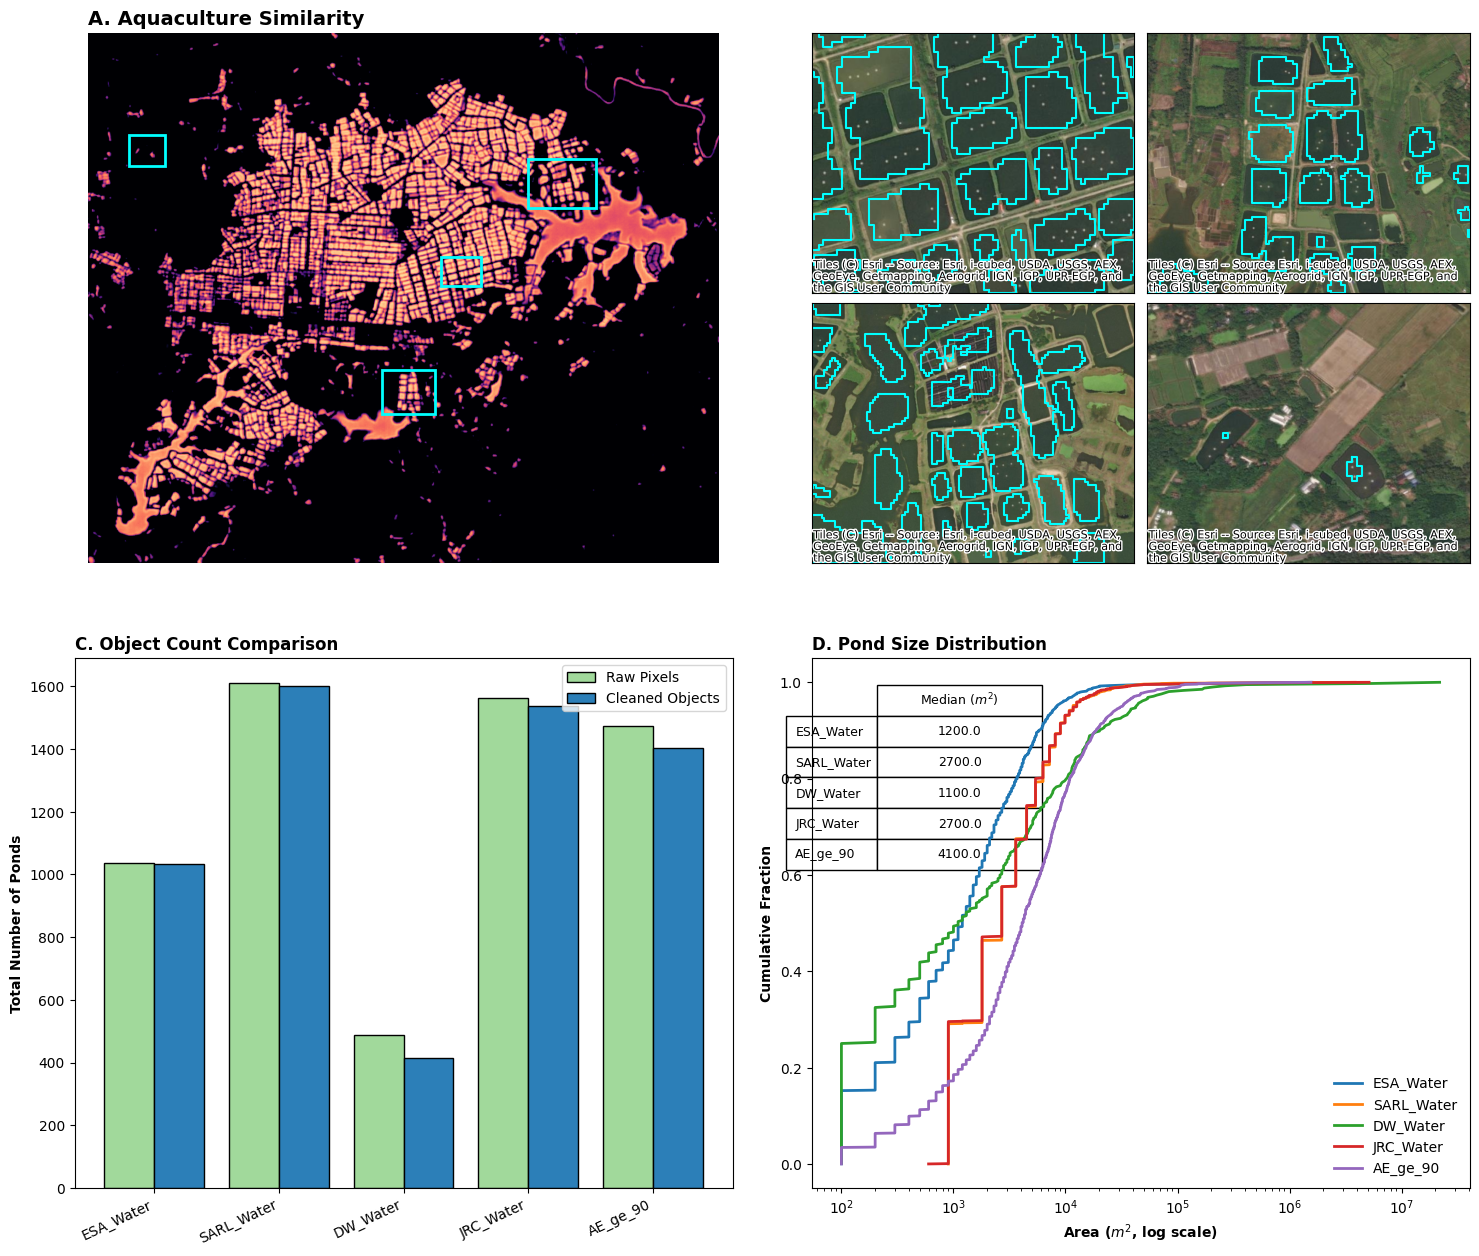

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from shapely.geometry import shape, box
from shapely.ops import unary_union
from pyproj import Transformer
import rasterio
from rasterio.features import shapes
import contextily as ctx
from scipy import ndimage as ndi

# --- 1. UPDATED USER SETTINGS FOR AQUACULTURE ---
TIF_PATH = "/content/drive/MyDrive/Alpha_Earth/Fish_Lakes/Water_Mask_and_Similarity_Final.tif"
# Removed HydroLAKES as it's too coarse for industrial ponds
SOURCES = ["ESA_Water", "SARL_Water", "DW_Water", "JRC_Water", "AE_ge_90"]
SIM_BAND_NAME = "Similarity_Score"

# CRITICAL: Set merge distance to nearly 0 to avoid merging adjacent ponds
MERGE_DIST_M = 1.0
PIXEL_SIZE_M = 10.0
PIXEL_AREA_M2 = 100.0
CONNECTIVITY = 4

# HAINAN COORDINATES (applied to all 4 slots as requested)


AOI_BBOXES = [
    (110.7810, 19.7019, 110.7873, 19.7065),
    (110.7716460365016, 19.681605061678635, 110.78010035931653, 19.688474304111704),
    (110.7947275527142,19.714264421853734 , 110.80549930411802 ,19.721980622205717),
    (110.73148642856107, 19.720965619743403, 110.73710833865628, 19.72585373157528)
]



# --- CORE LOGIC (AQUACULTURE TUNED) ---
structure = np.array([[0,1,0],[1,1,1],[0,1,0]], np.uint8) if CONNECTIVITY==4 else np.ones((3,3))

def consolidate_mask_close(mask01, merge_dist_m, pixel_size_m=10.0):
    # Skip dilation/erosion to prevent pond merging
    # Only fill holes (missing pixels inside a pond)
    m = ndi.binary_fill_holes(mask01.astype(bool))
    return m.astype(np.uint8)

def object_areas_m2(mask01):
    lab, n = ndi.label(mask01.astype(bool), structure=structure)
    if n==0: return np.array([])
    counts = ndi.sum(np.ones_like(lab, dtype=np.uint8), lab, np.arange(1,n+1))
    return (counts * PIXEL_AREA_M2) # Units: m^2

# --- DATA LOADING ---
with rasterio.open(TIF_PATH) as src:
    full_arr = src.read()
    # Handle cases where descriptions might be missing
    band_desc = list(src.descriptions) if src.descriptions[0] else SOURCES + [SIM_BAND_NAME]
    transform = src.transform
    crs = src.crs
    full_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

# --- STATS & POLYGONS ---
stats_rows, ecdf_curves, median_sizes = [], {}, {}
for s in SOURCES:
    try:
        idx = band_desc.index(s)
        raw = (full_arr[idx] > 0).astype(np.uint8)
        _, raw_n = ndi.label(raw.astype(bool), structure=structure)

        cons = consolidate_mask_close(raw, MERGE_DIST_M, PIXEL_SIZE_M)
        areas = object_areas_m2(cons)

        stats_rows.append({"s": s, "r": raw_n, "c": len(areas)})
        if len(areas) > 0:
            xs = np.sort(areas)
            ecdf_curves[s] = (xs, np.arange(1,len(xs)+1)/len(xs))
            median_sizes[s] = np.median(areas)
    except ValueError:
        continue

# Extract AE Polygons for Overlay
ae_idx = band_desc.index("AE_ge_90") if "AE_ge_90" in band_desc else 9
ae_mask = (full_arr[ae_idx] > 0).astype(np.uint8)
polys = [shape(g) for g,v in shapes(ae_mask, mask=ae_mask.astype(bool), transform=transform) if v==1]
merged_poly = unary_union(polys)

to_3857 = Transformer.from_crs(crs, "EPSG:3857", always_xy=True)

def project_poly(polygon):
    if polygon.is_empty: return None
    # Handle both Polygon and MultiPolygon
    if polygon.geom_type == 'Polygon':
        x, y = zip(*polygon.exterior.coords)
        x2, y2 = to_3857.transform(x, y)
        return shape({"type":"Polygon","coordinates":[list(zip(x2,y2))]})
    return None

aoi_polys_3857 = []
for bbox in AOI_BBOXES:
    aoi = box(*bbox)
    clipped = merged_poly.intersection(aoi)
    projected = []
    if not clipped.is_empty:
        if clipped.geom_type=="Polygon":
            p = project_poly(clipped)
            if p: projected.append(p)
        elif hasattr(clipped, 'geoms'):
            for p_part in clipped.geoms:
                p = project_poly(p_part)
                if p: projected.append(p)
    aoi_polys_3857.append(projected)

# --- FIGURE GENERATION ---
fig = plt.figure(figsize=(18, 15), facecolor='white')
gs = gridspec.GridSpec(2, 2, figure=fig, wspace=0.12, hspace=0.18)

# A. Similarity Map
ax1 = fig.add_subplot(gs[0,0])
sim_idx = band_desc.index(SIM_BAND_NAME) if SIM_BAND_NAME in band_desc else 10
im = ax1.imshow(full_arr[sim_idx], extent=full_extent, cmap='magma', vmin=0.7, vmax=1.0)
for i,bbox in enumerate(AOI_BBOXES):
    rect = patches.Rectangle((bbox[0],bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1],
                             linewidth=2.0, edgecolor='cyan', fill=False)
    ax1.add_patch(rect)
ax1.set_title("A. Aquaculture Similarity", fontweight='bold', loc='left', size=14)
ax1.axis('off')

# B. 2x2 Wayback Zoom
gs_inner = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[0,1], wspace=0.04, hspace=0.04)
for i, bbox in enumerate(AOI_BBOXES):
    ax = fig.add_subplot(gs_inner[i])
    x0, y0 = to_3857.transform(bbox[0], bbox[1])
    x1, y1 = to_3857.transform(bbox[2], bbox[3])
    ax.set_xlim(x0, x1); ax.set_ylim(y0, y1)
    ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, zoom=17, crs="EPSG:3857")
    for p in aoi_polys_3857[i]:
        x, y = zip(*p.exterior.coords)
        ax.plot(x, y, color='cyan', linewidth=1.5) # Cyan for high visibility
    ax.set_xticks([]); ax.set_yticks([])

# C. Bar Plot (Pond Counts)
ax3 = fig.add_subplot(gs[1,0])
df = pd.DataFrame(stats_rows)
x_pos = np.arange(len(df))
ax3.bar(x_pos-0.2, df['r'], 0.4, label="Raw Pixels", color='#a1d99b', edgecolor='black')
ax3.bar(x_pos+0.2, df['c'], 0.4, label="Cleaned Objects", color='#2c7fb8', edgecolor='black')
ax3.set_xticks(x_pos); ax3.set_xticklabels(df['s'], rotation=25, ha='right')
ax3.set_ylabel("Total Number of Ponds", fontweight='bold')
ax3.set_title("C. Object Count Comparison", fontweight='bold', loc='left')
ax3.legend()

# D. Size Distribution (m^2)
ax4 = fig.add_subplot(gs[1,1])
for s,(xs,ys) in ecdf_curves.items():
    ax4.plot(xs, ys, label=s, linewidth=2.0)
ax4.set_xscale("log")
ax4.set_xlabel("Area ($m^2$, log scale)", fontweight='bold')
ax4.set_ylabel("Cumulative Fraction", fontweight='bold')
ax4.set_title("D. Pond Size Distribution", fontweight='bold', loc='left')
ax4.legend(frameon=False, fontsize=10, loc='lower right')

# Median Table (m^2)
median_df = pd.DataFrame.from_dict(median_sizes, orient='index', columns=['Median ($m^2$)']).round(0)
table = ax4.table(cellText=median_df.values, colLabels=median_df.columns, rowLabels=median_df.index,
                  cellLoc='center', bbox=[0.10, 0.60, 0.25, 0.35])
table.set_fontsize(9)

plt.savefig("Aquaculture_Analysis_Final.png", dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipython-input-1275080643.py:32: RuntimeWarning: invalid value encountered in cast
  data_crop = full_arr[idx].astype(np.uint8)


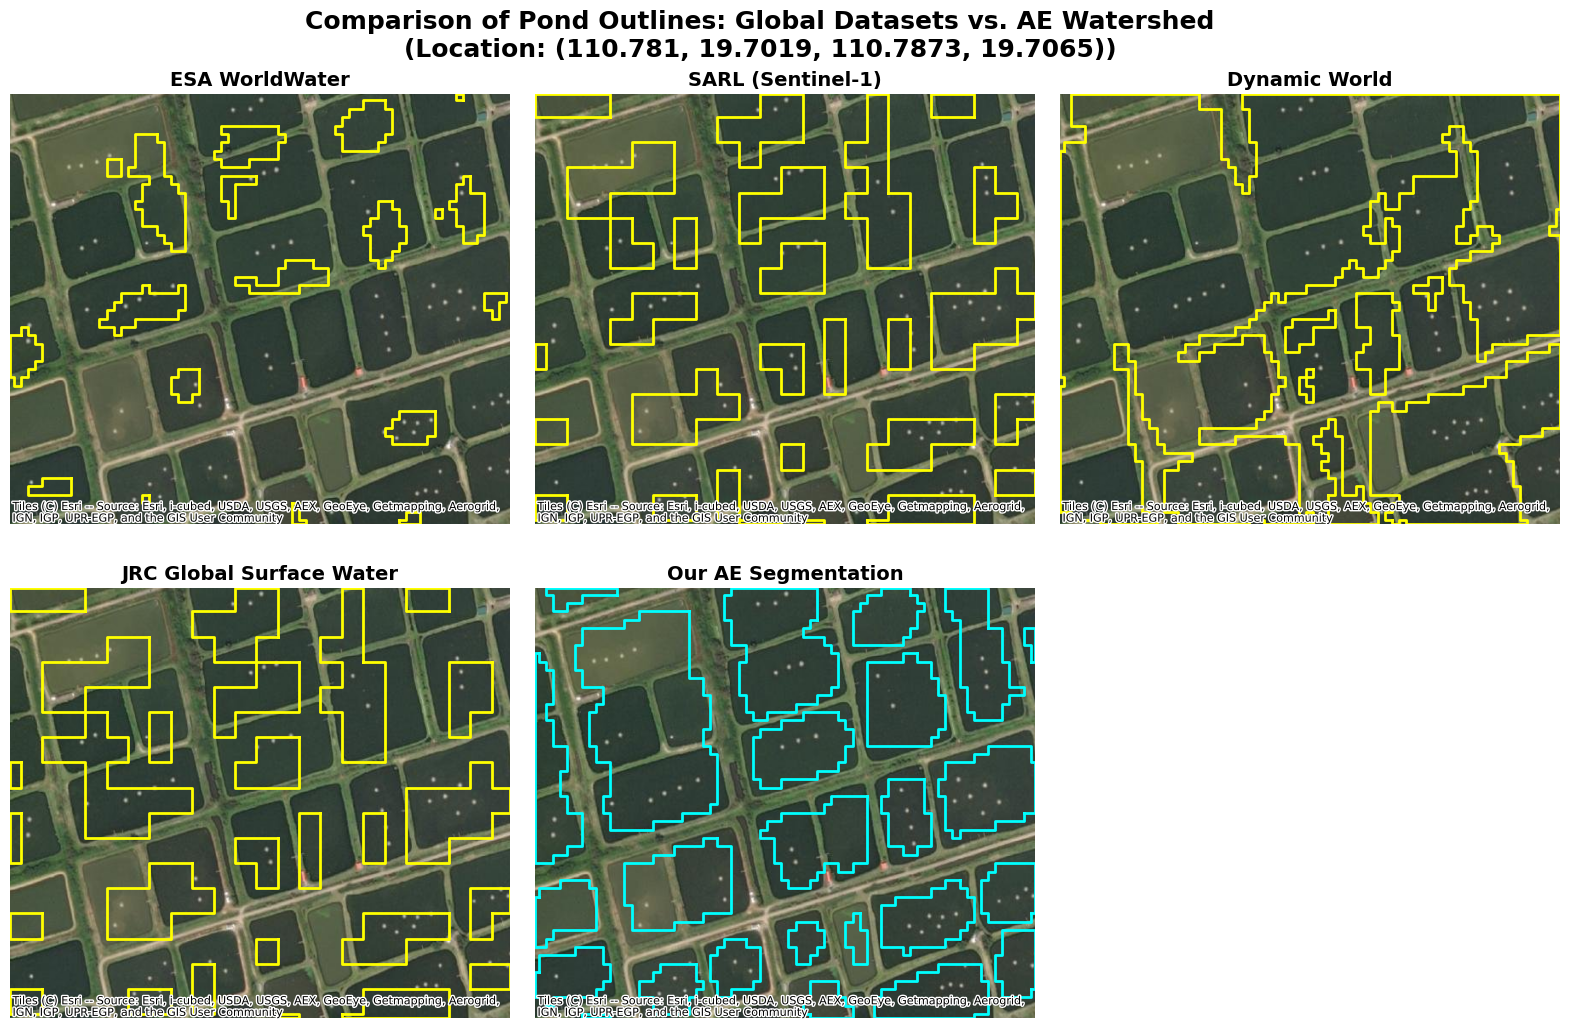

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import contextily as ctx
from rasterio.features import shapes
from shapely.geometry import shape

# 1. Setup the display grid (2 rows, 3 columns for 6 products)
fig = plt.figure(figsize=(20, 12), facecolor='white')
gs = gridspec.GridSpec(2, 3, wspace=0.05, hspace=0.15)

# 2. Define products to show (matching your stack indices)
# We add AE_ge_90 as the 6th product
compare_sources = ["ESA_Water", "SARL_Water", "DW_Water", "JRC_Water", "AE_ge_90"]
# Product aliases for titles
titles = ["ESA WorldWater", "SARL (Sentinel-1)", "Dynamic World", "JRC Global Surface Water", "Our AE Segmentation"]

# 3. Use your Hainan BBox
x0, y0 = to_3857.transform(bbox[0], bbox[1])
x1, y1 = to_3857.transform(bbox[2], bbox[3])

for i, s_name in enumerate(compare_sources):
    ax = fig.add_subplot(gs[i])

    # Set extent and add satellite background
    ax.set_xlim(x0, x1)
    ax.set_ylim(y0, y1)
    ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, zoom=17, crs="EPSG:3857", attribution=None)

    # Vectorize the specific reference band for this zoom area
    idx = band_desc.index(s_name)
    data_crop = full_arr[idx].astype(np.uint8)

    # Extract shapes for the current product
    ref_gen = shapes(data_crop, mask=(data_crop > 0), transform=transform)

    # Plot each polygon found in this product
    for geom, val in ref_gen:
        poly = shape(geom)
        # Intersection with our bbox to keep plot clean
        clipped = poly.intersection(box(*bbox))
        if not clipped.is_empty:
            # Project to Web Mercator for contextily
            if clipped.geom_type == 'Polygon':
                px, py = zip(*clipped.exterior.coords)
                px2, py2 = to_3857.transform(px, py)
                ax.plot(px2, py2, color='yellow' if i < 4 else 'cyan', linewidth=2)
            elif hasattr(clipped, 'geoms'):
                for part in clipped.geoms:
                    px, py = zip(*part.exterior.coords)
                    px2, py2 = to_3857.transform(px, py)
                    ax.plot(px2, py2, color='yellow' if i < 4 else 'cyan', linewidth=2)

    ax.set_title(titles[i], fontweight='bold', fontsize=14)
    ax.set_xticks([]); ax.set_yticks([])
    for spine in ax.spines.values(): spine.set_visible(False)

# Add a final label or legend
plt.suptitle(f"Comparison of Pond Outlines: Global Datasets vs. AE Watershed\n(Location: {bbox})",
             fontsize=18, fontweight='bold', y=0.95)

plt.savefig("Ref_Product_Comparison_Zoom.png", dpi=300, bbox_inches='tight')
plt.show()

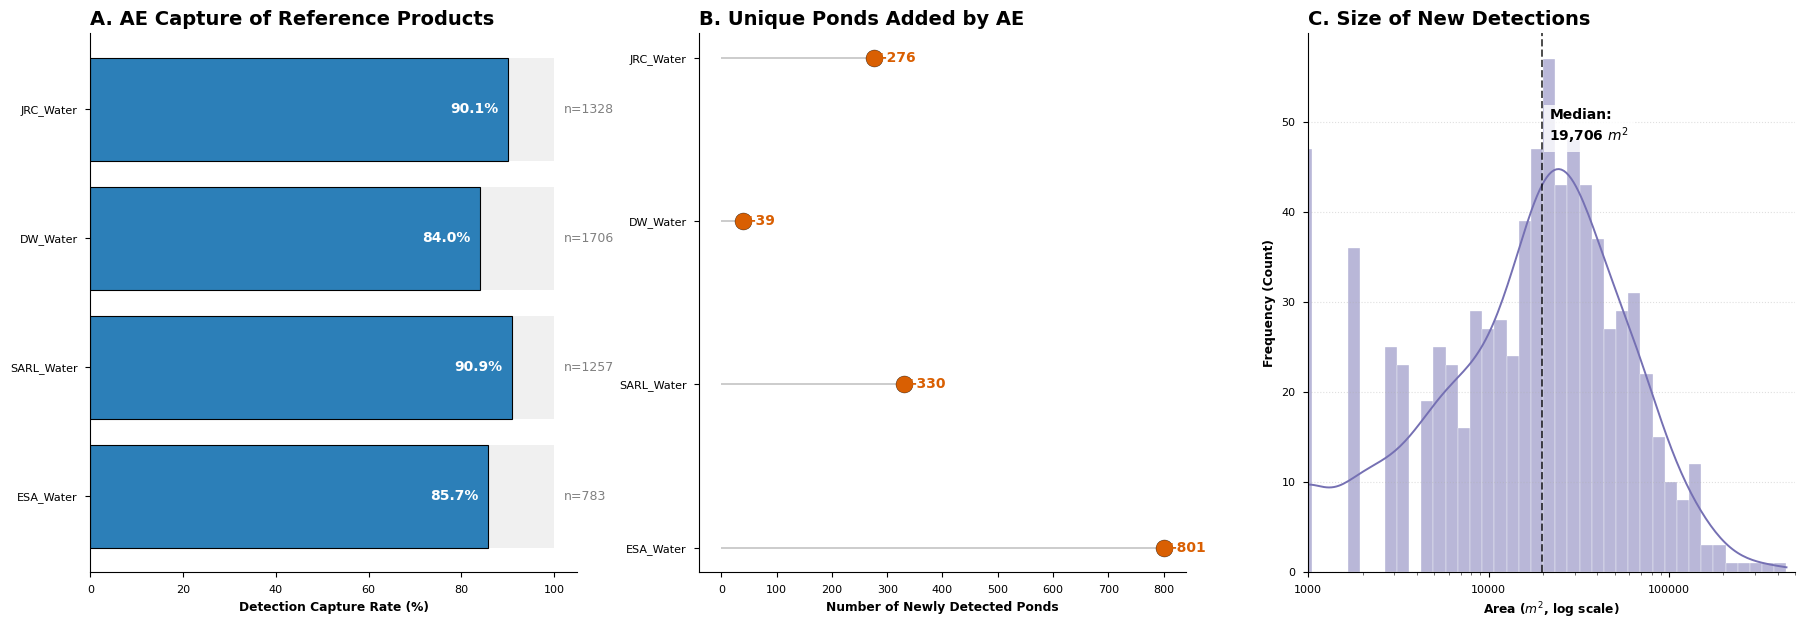

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from shapely.ops import unary_union
from rasterio.features import shapes
from shapely.geometry import shape
from matplotlib.ticker import ScalarFormatter

# --- 1. DYNAMIC CALCULATION ENGINE ---
comparison_stats = []
ae_new_discovery_areas = []

# Master union of AE ponds for "Not Detected" logic
ae_union = unary_union(polys)

for s in SOURCES:
    if s == "AE_ge_90": continue

    idx = band_desc.index(s)
    ref_mask = (full_arr[idx] > 0).astype(np.uint8)

    # Vectorize Reference Band
    ref_gen = shapes(ref_mask, mask=(ref_mask > 0), transform=transform)
    ref_polys = [shape(g) for g, v in ref_gen]
    ref_union = unary_union(ref_polys) if ref_polys else None

    supported = 0
    new_discovery = 0

    for p in polys:
        # Check intersection
        if ref_union and p.intersects(ref_union):
            supported += 1
        else:
            new_discovery += 1
            # Calculate area for Panel C (using first source to avoid duplicates)
            if s == SOURCES[0]:
                # Conversion from degrees to m2 (Hainan latitude adjustment)
                area_m2 = p.area * 1.11e11
                # FILTER: focus strictly on 0 - 100k m2
                if 0 < area_m2 <= 500000:
                    ae_new_discovery_areas.append(area_m2)

    # Missed by AE
    not_detected = 0
    for rp in ref_polys:
        if not rp.intersects(ae_union):
            not_detected += 1

    comparison_stats.append({
        "Source": s,
        "Supported": supported,
        "Not_Detected": not_detected,
        "New_Discovery": new_discovery
    })

df_metrics = pd.DataFrame(comparison_stats)

# --- 2. FIGURE CONFIG ---
plt.style.use("seaborn-v0_8-paper")
fig = plt.figure(figsize=(22, 7), facecolor='white')
gs = gridspec.GridSpec(1, 3, figure=fig, wspace=0.25)

# --- PANEL A: CAPTURE RATE ---
ax1 = fig.add_subplot(gs[0, 0])
total_ref = df_metrics["Supported"] + df_metrics["Not_Detected"]
pct_supp = (df_metrics["Supported"] / total_ref) * 100

ax1.barh(df_metrics["Source"], [100]*len(df_metrics), color='#f0f0f0')
ax1.barh(df_metrics["Source"], pct_supp, color='#2c7fb8', edgecolor='black', linewidth=0.8)

for i, (pct, n) in enumerate(zip(pct_supp, total_ref)):
    ax1.text(pct - 2, i, f"{pct:.1f}%", va='center', ha='right', color='white', fontweight='bold', fontsize=10)
    ax1.text(102, i, f"n={n}", va='center', color='grey', fontsize=9)

ax1.set_xlabel("Detection Capture Rate (%)", fontweight='bold')
ax1.set_title("A. AE Capture of Reference Products", fontweight='bold', loc='left', size=14)
ax1.spines[['right', 'top']].set_visible(False)

# --- PANEL B: ADDITIONAL DISCOVERY ---
ax2 = fig.add_subplot(gs[0, 1])
ax2.hlines(y=df_metrics["Source"], xmin=0, xmax=df_metrics["New_Discovery"], color='grey', alpha=0.4)
ax2.scatter(df_metrics["New_Discovery"], df_metrics["Source"], s=150, color='#d95f02', edgecolor='black', zorder=3)

for i, v in enumerate(df_metrics["New_Discovery"]):
    ax2.text(v + 3, i, f"+{v}", va='center', fontweight='bold', color='#d95f02', fontsize=10)

ax2.set_xlabel("Number of Newly Detected Ponds", fontweight='bold')
ax2.set_title("B. Unique Ponds Added by AE", fontweight='bold', loc='left', size=14)
ax2.spines[['right', 'top']].set_visible(False)

# --- PANEL C: FOCUSED FREQUENCY DISTRIBUTION ---
ax3 = fig.add_subplot(gs[0, 2])
if ae_new_discovery_areas:
    data_c = np.array(ae_new_discovery_areas)

    # log_scale=True with 40 bins ensures high density in small-pond areas
    sns.histplot(data_c, bins=40, ax=ax3, color='#7570b3', kde=True,
                 alpha=0.5, edgecolor='white', log_scale=True)

    ax3.set_xlabel("Area ($m^2$, log scale)", fontweight='bold')
    ax3.set_ylabel("Frequency (Count)", fontweight='bold')
    ax3.set_title(f"C. Size of New Detections", fontweight='bold', loc='left', size=14)

    # Set limits to focus on the small range requested
    ax3.set_xlim(999, 500000)

    # Add clear integer labels instead of scientific notation
    ax3.xaxis.set_major_formatter(ScalarFormatter())

    # Median annotation
    median_val = np.median(data_c)
    ax3.axvline(median_val, color='black', linestyle='--', alpha=0.7)
    ax3.text(median_val * 1.1, ax3.get_ylim()[1] * 0.8, f'Median:\n{median_val:,.0f} $m^2$',
             fontweight='bold', fontsize=10, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

ax3.grid(axis='y', ls=':', alpha=0.4)
ax3.spines[['right', 'top']].set_visible(False)

plt.tight_layout()
plt.savefig("Publication_Ready_Analysis.png", dpi=300, bbox_inches='tight')
plt.show()

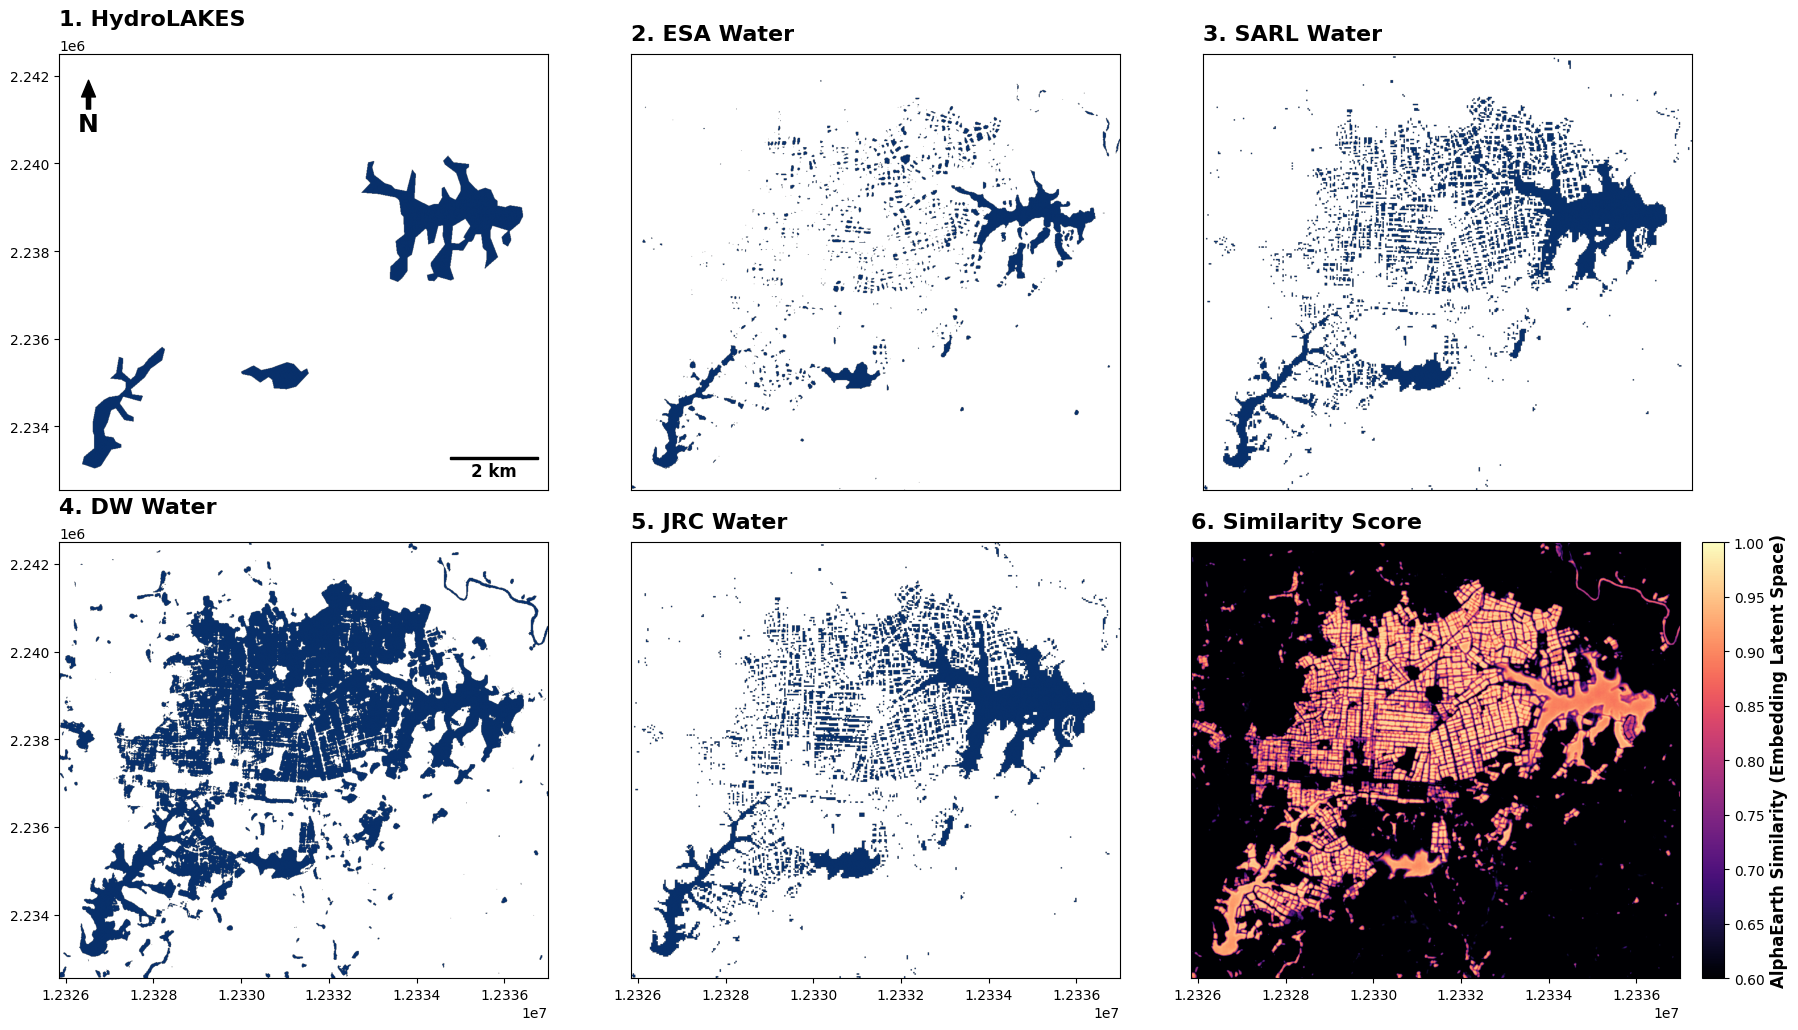

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import rasterio
import contextily as ctx
from pyproj import Transformer

PRODUCTS = ["HydroLAKES", "ESA_Water", "SARL_Water", "DW_Water", "JRC_Water", "Similarity_Score"]
with rasterio.open(TIF_PATH) as src:
    full_arr = src.read()
    band_desc = list(src.descriptions)
    full_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
    src_crs = src.crs

# Transformer for Web Mercator (Required for contextily)
to_3857 = Transformer.from_crs(src_crs, "EPSG:3857", always_xy=True)
x0, y0 = to_3857.transform(full_extent[0], full_extent[2])
x1, y1 = to_3857.transform(full_extent[1], full_extent[3])

# --- FIGURE GENERATION ---
plt.style.use("default")
fig = plt.figure(figsize=(22, 12), facecolor='white')
gs = gridspec.GridSpec(2, 3, figure=fig, wspace=0.02, hspace=0.12)

# Professional Color Palette
for i, source in enumerate(PRODUCTS):
    ax = fig.add_subplot(gs[i])

    # 1. Background Imagery: Very subtle (80% transparent) to make masks "pop"
    ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, zoom=14,
                    crs="EPSG:3857", attribution="", alpha=0.2)

    data = full_arr[band_desc.index(source)]

    if source == "Similarity_Score":
        # PANEL 6: The "Rich Embedding" Signal
        # We use a solid background for the final panel to show the "Continuous Signal"
        # as mentioned in your supporting points.
        im = ax.imshow(data, extent=[x0, x1, y0, y1], cmap='magma', vmin=0.6, vmax=1.0)
        cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label("AlphaEarth Similarity (Embedding Latent Space)", fontweight='bold', size=12)
    else:
        # PANELS 1-5: Product Disagreement
        # Non-water is completely transparent; Water is a solid, clean Blue
        water_mask = np.ma.masked_where(data == 0, data)
        ax.imshow(water_mask, extent=[x0, x1, y0, y1], cmap='Blues_r', alpha=1.0)

    # 2. Annotations for Figure 1 Logic
    if i == 0:
        # North Arrow
        ax.annotate('N', xy=(0.06, 0.94), xytext=(0.06, 0.84),
                    arrowprops=dict(facecolor='black', width=3, headwidth=10),
                    ha='center', va='center', fontsize=18, fontweight='bold', xycoords='axes fraction')
        # Scale Bar
        scalebar = AnchoredSizeBar(ax.transData, 2000, '2 km', 'lower right',
                                   pad=0.5, color='black', frameon=False, size_vertical=40,
                                   fontproperties=fm.FontProperties(size=12, weight='bold'))
        ax.add_artist(scalebar)

    # Titles and Neatlines
    clean_name = source.replace('_', ' ')
    ax.set_title(f"{i+1}. {clean_name}", loc='left', fontweight='bold', size=16, pad=10)

    ax.set_xlim(x0, x1)
    ax.set_ylim(y0, y1)

    # Remove interior ticks for a high-end publication look
    if i < 3: ax.set_xticks([])
    if i % 3 != 0: ax.set_yticks([])
    ax.tick_params(axis='both', which='major', labelsize=10)

plt.savefig("Figure1_AlphaEarth_vs_GlobalProducts.png", dpi=300, bbox_inches='tight')
plt.show()

Calculating polygon counts for all reference products...

--- FINAL POLYGON COUNTS ---
                 Product  Total_Polygons
0  Source (Your GeoJSON)            1726
1             SARL_Water            1609
2              ESA_Water            1035
3              JRC_Water            1562
4               DW_Water             487
5               AE_ge_90            1709


ValueError: crs must be provided if source is not provided, such as EPSG:3857

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 21.4 MB/s eta 0:00:00
  Attempting uninstall: xarray
    Found existing installation: xarray 2025.12.0
    Uninstalling xarray-2025.12.0:
      Successfully uninstalled xarray-2025.12.0
